## 作業工程計画

1. 説明変数から採点回を削除。（先方から2020年データ来たら追加を検討）
2. AIモデル（学年混合モデル、学年別（1〜3年）モデル）に準じてデータを訓練用と検証用に分ける
3. 科目別のデータセットを作成し、分野の少ない国語から決定木で分析
4. AI想定ペースと、実績値との誤差を集計
5. 誤差の最大値でモデルを評価
6. 評価結果から、説明変数の組み合わせ増減を検討
7. 2〜4を各モデルに対して繰り返し、モデルの改良を行う
8. 作成した各モデルとその結果から、一番誤差の少ないものを選択し、報告に使用


### 参考サイト

1. Scikit-learn
https://scikit-learn.org/stable/modules/tree.html
2. DecisionTreeRegressor
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
3. Decision Tree Regression https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#sphx-glr-auto-examples-tree-plot-tree-regression-py
4. DXCEL WAVE https://di-acc2.com/programming/python/13875/

## ライブラリの読み込み

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import re 

"""
機械学習ライブラリの準備
"""

from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor #決定木
import lightgbm as lgb #lightGBM

In [7]:
"""
機械学習ライブラリの準備
"""

from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor #決定木
import lightgbm as lgb #lightGBM

## 村上さんツールボックス

In [33]:
"""
村上さんtoolbox
"""
# pandas 基礎集計クラス
import numpy as np
import pandas as pd
import copy
import seaborn as sns
from itertools import combinations

#http://qiita.com/tanemaki/items/2ed05e258ef4c9e6caac

# Jupyterで表示するためには、最初に以下を実行すること
%matplotlib inline

# Static Classで設計する
class pandas_tool:
    
    # All in one チェック（Jupyterのみ）
    def all_basic_summary_jupyter(df):
        print("■ 型の確認")
        display(pandas_tool.type(df))
        print("■ 数値型の確認")
        display(pandas_tool.summary(df)[0])
        print("■ カテゴリ型の確認")
        cate_var_data = list(df.select_dtypes(include=['object']).columns)
        ret = pandas_tool.freq(df,cate_var_data)
        for d in ret:
            display(pd.DataFrame(d))
            print("---------------")
        print("■ 欠損の確認")
        display(pandas_tool.check_missing(df))
    
    # 相関関係可視化（Jupyterのみ）
    def all_value_relation_visualize(df):
        #sns.set_context("poster", 1.2, {"lines.linewidth": 3})
        sns.pairplot(df,size=5)
    
    # カテゴリ変数でのヒートマップ（Jupyterのみ）
    def make_heatmap(df,x,y,value):
        target_df = df.pivot_table(index=x,values=value,columns=y)
        sns.heatmap(target_df, annot=True, fmt='1.1f', cmap='Blues')
    
    # 散布図（Jupyterのみ）
    def make_scatter_chart(df,x,y):
        #sns.jointplot(x=x, y=y, data=df, kind="hex")
        sns.jointplot(x=x, y=y, data=df)
    
    # 組み合わせでヒートマップを作成（Jupyterのみ）
    def all_make_heatmap(df,var_list,value):
        col_num = 2
        var_list_set = list(combinations(var_list,2))
        
        fig, axes = plt.subplots(int(len(var_list_set)/col_num)+1, col_num, figsize=(18,3+6.5*int(len(var_list_set)/col_num)))
        
        for i,target in enumerate(var_list_set):
            target_df = df.pivot_table(index=target[0],values=value,columns=target[1])
            sns.heatmap(target_df, annot=True, fmt='1.1f', cmap='Blues', ax=axes[int(i/col_num), i%col_num])
            
        plt.tight_layout()
    
    # 数値集計
    def summary(df,view=False):
        ret=df.describe()
        mis_ret=df.isnull().sum()
        if view:
            param=pd.get_option("display.max_columns")
            pd.set_option("display.max_columns",1000)
            print("・統計量")
            print(ret)
            print("・欠損値")
            print(mis_ret)
            pd.set_option("display.max_columns",param)
        return ret,mis_ret
    
    # 型チェック
    def type(df,view=False):
        ret = df.dtypes
        if view:
            param=pd.get_option("display.max_rows")
            pd.set_option("display.max_rows",1000)
            print(ret)
            pd.set_option("display.max_rows",param)
        return ret
    
    # 欠損チェック
    def check_missing(df,view=False):
        not_null_df=df.notnull()
        ret=pd.DataFrame()
        for name in not_null_df.columns:
            tmp_df=not_null_df[name].value_counts()
            tmp_df.name=name
            ret = pd.concat([ret,tmp_df],axis=1)
        
        if view:
            param=pd.get_option("display.max_columns")
            pd.set_option("display.max_columns",1000)
            print(ret)
            pd.set_option("display.max_columns",param)
        
        return ret
    
    # 欠損値のオブザベーションを抽出
    def get_miss_data(df,column,view=False):
        ret=df[df[column].isnull()]
        if view:
            param=pd.get_option("display.max_columns")
            pd.set_option("display.max_columns",1000)
            print(ret)
            pd.set_option("display.max_columns",param)
        return ret
    
    # 欠損値を中央値で補完
    def fill_miss_med(df,var_name):
        var=df[var_name].median()
        df[var_name].fillna(var,inplace=True)
        return df
    
    # 欠損値を0で補完
    def fill_miss_zero(df,var_name):
        df[var_name].fillna(0,inplace=True)
        return df
    
    # 特定の値を欠損とみなす
    def apply_miss_value(df,var_name,value):
        df[var_name]=df[var_name].replace(value,np.nan)
        return df
    
    # 重複チェック
    def check_dup(df,columns,view=False):
        ret=pd.DataFrame()
        for name in columns:
            dup_cnt=df[name].duplicated().sum()
            tmp_df = pd.DataFrame({'var_name':[name],'dup_cnt':[dup_cnt]})
            ret = pd.concat([ret,tmp_df],axis=0,ignore_index= True)
        
        if view:
            param=pd.get_option("display.max_columns")
            pd.set_option("display.max_columns",1000)
            print(ret)
            pd.set_option("display.max_columns",param)
        
        return ret
    
    # 組み合わせ重複チェック
    def check_dup_comb(df,columns,view=False):
        ret = df[columns].duplicated().sum()
        if view:
            param=pd.get_option("display.max_columns")
            pd.set_option("display.max_columns",1000)
            print(ret)
            pd.set_option("display.max_columns",param)
        
        return ret
    
    # ユニークデータ取得
    def get_uniq_data(df,uniq_key,sort_key,keep='first'):
        ret = df.sort_values(by=sort_key)
        ret.drop_duplicates(subset=uniq_key, keep=keep, inplace=True)
        return ret
    
    # カテゴリ集計
    def freq(df,columns,view=False):
        ret=list()
        for name in columns:
            tmp_df=df[name].value_counts()
            tmp_df.name=name
            #ret = pd.concat([ret,tmp_df],axis=1)
            ret.append(tmp_df)
        
        if view:
            param=pd.get_option("display.max_columns")
            pd.set_option("display.max_columns",1000)
            for r in ret:
                print(r)
                #display(r)
            pd.set_option("display.max_columns",param)
        
        return ret
    
    # 複雑な集計
    def tabulate(df,row,col=None,var='',func=np.sum,view=False):
        if var == '':
            tmp_df=df.reset_index(drop=False,inplace=False)
            ret=pd.pivot_table(data=tmp_df, values='index', index=row, columns=col, aggfunc='count', dropna=False, fill_value=0 ,margins = False)
            tmp_df=None
        else:
            ret=pd.pivot_table(data=df, values=var, index=row, columns=col, aggfunc=func, dropna=False, fill_value=0 ,margins = False)
        if view:
            param=pd.get_option("display.max_columns")
            pd.set_option("display.max_columns",1000)
            print(ret)
            pd.set_option("display.max_columns",param)
        
        return ret
    
    # マージ
    def merge(df1,df2,key,how,view=True):
        if view:
            print("df1のキー重複")
            pandas_tool.check_dup_comb(df1,key,True)
            print("df2のキー重複")
            pandas_tool.check_dup_comb(df2,key,True)
            
            print("df1のオブザベーション:{0}".format(len(df1)))
            print("df2のオブザベーション:{0}".format(len(df2)))
        
        ret=pd.merge(df1,df2,how=how,on=key)
        
        if view:
            print("mergeのオブザベーション:{0}".format(len(ret)))
        
        return ret
    
    # Rank
    def rank(df,var,num,suffix='_rank',check=False):
        labels=[i for i in range(0,num)]
        df[var+suffix]=pd.qcut(df[var], num, labels=labels)
        
        # check data
        if check:
            ret=pd.DataFrame()
            max_df=pandas_tool.tabulate(df=df,row=[var+suffix],var=var,func=np.max,view=False)
            max_df.name='max'
            min_df=pandas_tool.tabulate(df=df,row=[var+suffix],var=var,func=np.min,view=False)
            min_df.name='min'
            cnt_df=pandas_tool.tabulate(df=df,row=[var+suffix],var=var,func='count',view=False)
            cnt_df.name='count'
            ret=pd.concat([ret,min_df,max_df,cnt_df],axis=1)
            return df,ret
            
        return df
    
    # Rank適用(min基準)
    def apply_rank(df,rank_df):
        tmp_df=copy.deepcopy(rank_df)
        tmp_df.reset_index(drop=False,inplace=True)
        target_name=tmp_df.columns[3]
        tmp_df.columns=["rank","min","max","cnt"]
        
        def judge_thld(row):
            ret_var = -1
            cond_list = ["if 0 : ret_var = 0"]
            
            for i in range(1,len(tmp_df)):
                cond_list.append("elif row < " +str(tmp_df.ix[i,'min'])+ " : ret_var = " + str(tmp_df.ix[i-1,'rank']))
            
            cond_list.append("else: ret_var = " + str(tmp_df.ix[len(tmp_df)-1,'rank']))
            cond_str="\r\n".join(cond_list)
            # ローカル辞書をexecと共有する
            local_dict=locals()
            exec(cond_str,local_dict)
            return local_dict["ret_var"]
        
        df[target_name+"_rank"]=df[target_name].apply(judge_thld)
        return df
    
    # Min%以下はMin%点に、Max%以上はMax%点にクリップする
    def clip_min_max(df,col_list,apply_df=None,max_pct=0.99,min_pct=0.01):
        p_min = df[col_list].quantile(min_pct)
        p_max = df[col_list].quantile(max_pct)
        
        df[col] = df[col_list].clip(p_min,p_max,axis=1)
        
        # もしも適用先のデータがあるならば（例えば検証データ）対応
        if apply_df is not None:
            apply_df[col] = apply_df[col_list].clip(p_min,p_max,axis=1)
            return df,apply_df
        else:
            return df
    
    
    # 文字列→数値変換
    def conv_float(df,column,percent_flg=False):
        
        def conv_f(row):
            if row[column] == "" or row[column] is np.nan:
                return np.nan
            else:
                return float(row[column])
        
        df[column]=df[column].str.replace("\\","").str.replace(",","").str.replace("%","").str.strip()
        df[column]=df.apply(conv_f,axis=1)
        
        if percent_flg:
            df[column]=df[column]/100
        
        return df

## データの読み込み

In [2]:
#データ読み込み
"""
data1から分野を抜き出したcsvファイルを読み込む
"""

name_csv = "crlea1_dm_0518.csv" #ファイル名
path_folder = r"/Users/s.ogura/Documents/CRLEA/data/intermediatedata"#データが置いてあるフォルダパス
path_file = r'{p}/{n}'.format(p = path_folder, n = name_csv)#ファイルパスとファイル名

# csvファイルの読み込みと空のリストに追加
df = pd.read_csv(filepath_or_buffer = path_file, sep=",",
                 usecols=['科目',
                          '分野名（修正）',
                          'ポイント採点',
                          '採点回',
                          '学年',
                          'ポイント数',
                          '文字数',
                          '配点',
                          # '企画ペース',
                          '最終ペース'])

#列のリネーム
df = df.rename(columns={'分野名（修正）':'分野'})
raw_df = df
raw_df.head()

,科目,文字数,ポイント数,配点,最終ペース,採点回,学年,分野,ポイント採点
0,国語,60.0,1,6.0,143.4,冬,1,評論,1
1,国語,40.0,1,5.0,449.8,冬,1,評論,0
2,国語,60.0,1,5.0,108.0,冬,1,小説,1
3,国語,40.0,1,4.0,124.9,冬,1,小説,0
4,国語,12.0,1,5.0,846.9,冬,1,古文,0


## データの準備

In [3]:
"""
テストデータの設定
1.国語科目だけ抽出
2.one hot encoding
3.説明変数だけ、目的変数だけのデータフレーム作成
4.訓練用、検証用にデータフレームを採点回の列を使って分離
5.説明変数から採点回を削除
"""
#生データの代入
df = raw_df

#国語科目だけを選択し、科目の列を削除
df = df[df['科目'] == '国語']
df = df.drop(columns = ["科目"])

#名義変数のエンコーディング pandas get_dummies関数でone hot encording
df = pd.get_dummies(df)

#上記のデータセットを訓練用と検証用で分ける
df_X = df.drop(columns = "最終ペース")#目的変数を除外した（説明変数だけ含む）データフレーム
df_y = df.loc[:,['採点回_夏','最終ペース']]#目的変数だけ含むデータフレーム


#秋冬が訓練用
X_train = df_X[df_X['採点回_夏'] != 1]
y_train = df_y[df_y['採点回_夏'] != 1]
#夏が検証用
X_test = df_X[df_X['採点回_夏'] == 1]
y_test = df_y[df_y['採点回_夏'] == 1]


#説明変数から採点回を削除

#説明変数
X_train = X_train.drop(columns = ["採点回_夏","採点回_秋","採点回_冬"])
X_test = X_test.drop(columns = ["採点回_夏","採点回_秋","採点回_冬"])

X_train_feature_names = X_train.columns.values.tolist()

#目的変数
y_train = y_train.drop(columns = "採点回_夏")
y_test = y_test.drop(columns = "採点回_夏")

## DecisionTreeRegressorメソッドの概要

|引数名|概要|デフォルト|
| :---- | :---- | :---- |
|criterion|不純度を測定する基準（平均二乗誤差、平均絶対誤差など）|‘mse’|
|splitter|条件探索アルゴリズムを選択するオプション（’best’と’rondom’が指定可能）|‘best’|
|max_depth|決定木のノード深さの制限値。ツリーが深くなりすぎて過学習の状態に陥った際は、このパラメータが正則化の役割を果たす。|None|
|min_samples_split|ノードを分割するために必要なサンプルの最小値|2|
|min_samples_leaf|1ノードの深さを作成するために必要となるデータ数の最小値。指定した値以上のデータ数を持たないノードは作られない。|1|
|min_weight_fraction_leaf|サンプルの重みを考慮した上でのmin_samples_leafに該当|0.0|
|max_features|ランダムに指定する説明変数の数(全ての説明変数がモデル学習に活用されるわけではなく、ランダムに割り振られる）|None|
|random_state|乱数シード|None|
|max_leaf_nodes|作成される決定木の葉の数を、指定した値以下に制御する|None|
|min_impurity_decrease|決定木の成長の早期停止するための閾値。不純度が指定の値より減少した場合、ノードを分岐し、不純度が指定の値より減少しなければ分岐を抑制。|0.0|
|ccp_alpha|ccp_alphaが大きいほどプルーニングされるノードの数が増加。プルーニングとは、精度低下をできるだけ抑えながら過剰な重みを排除するプロセスを指す。|0.0|


## Decition Trees モデル学習

In [5]:
""" モデル学習 """
# 決定木回帰モデルのパラメータ
model = DecisionTreeRegressor(criterion='mse', 
                                   splitter='best', 
                                   max_depth=None, 
                                   min_samples_split=2, #3,4,5とか？
                                   min_samples_leaf=1,#2とか 
                                   min_weight_fraction_leaf=0.0,
                                   max_features=None, 
                                   random_state=None, 
                                   max_leaf_nodes=None, 
                                   min_impurity_decrease=0.0, 
                                   ccp_alpha=0.0
                                  )

#上記のパラメータでモデルを学習する
model.fit(X_train, y_train)
y_pred  = model.predict(X_test)

In [9]:
"""
予測結果および予測結果と実測値の差分のデータフレーム作成
"""
df_res=[]
df_res = df[df['採点回_夏'] == 1]#検証に使った説明変数データ
df_res.loc[:,'AI想定ペース']= y_pred #上のデータに予測値をマージ
df_res.loc[:,'誤差']= df_res['AI想定ペース']-df_res['最終ペース']#実測値と予測値の差分を列に追加 

/Users/s.ogura/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


# 結果の確認

In [108]:
df_res.head()

,文字数,ポイント数,配点,最終ペース,学年,ポイント採点,採点回_冬,採点回_夏,採点回_秋,分野_古文,分野_小説,分野_漢文,分野_評論,分野_随筆,AI想定ペース,誤差
82,30.0,2,4.0,273.3,1,0,0,1,0,0,0,0,1,0,274.8,1.5
83,60.0,3,6.0,133.1,1,1,0,1,0,0,0,0,1,0,143.4,10.3
84,60.0,3,6.0,93.5,1,1,0,1,0,0,1,0,0,0,107.3,13.8
85,25.0,2,5.0,259.2,1,0,0,1,0,1,0,0,0,0,192.8,-66.4
86,40.0,3,6.0,153.6,1,0,0,1,0,1,0,0,0,0,192.8,39.2


In [109]:
pandas_tool.summary(df_res.loc[:,['最終ペース','AI想定ペース','誤差']])

(            最終ペース      AI想定ペース           誤差
 count   30.000000    30.000000    30.000000
 mean   229.703333   300.593333    70.890000
 std    105.580626   303.666317   225.423268
 min     93.500000   107.300000  -112.500000
 25%    139.225000   169.600000   -30.375000
 50%    235.450000   175.350000    12.050000
 75%    272.175000   298.200000    52.325000
 max    554.200000  1699.600000  1145.400000,
 最終ペース      0
 AI想定ペース    0
 誤差         0
 dtype: int64)

In [110]:
print('差分の最大値',max(df_res['誤差'].values.tolist()))

差分の最大値 1145.3999999999999


## 変数の重要度

In [6]:
from sklearn import tree
import graphviz


# y_trainをfloatからintに変換
y = np.asarray(y_train, dtype = int)

#分類
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train.values, y)

dot_data = tree.export_graphviz(model, out_file=None,#modelは上の別のセルで定義していた。clfは使ってない。
                                feature_names= X_train_feature_names,
                                # class_names=iris.target_names,
                                filled=True, rounded=True, special_characters=True
                               ) 
graph = graphviz.Source(dot_data) 

"""グラフの保存"""
# name_file = "DTs" #ファイル名
# path_folder = r"/Users/s.ogura/Documents/CRLEA/data/output"#フォルダパス
# path_file = r'{p}/{n}'.format(p = path_folder, n = name_file)#ファイルパスとファイル名
# graph.render(path_file) 

'グラフの保存'

In [8]:
X_train_feature_names

['文字数',
 'ポイント数',
 '配点',
 '学年',
 'ポイント採点',
 '分野_古文',
 '分野_小説',
 '分野_漢文',
 '分野_評論',
 '分野_随筆']

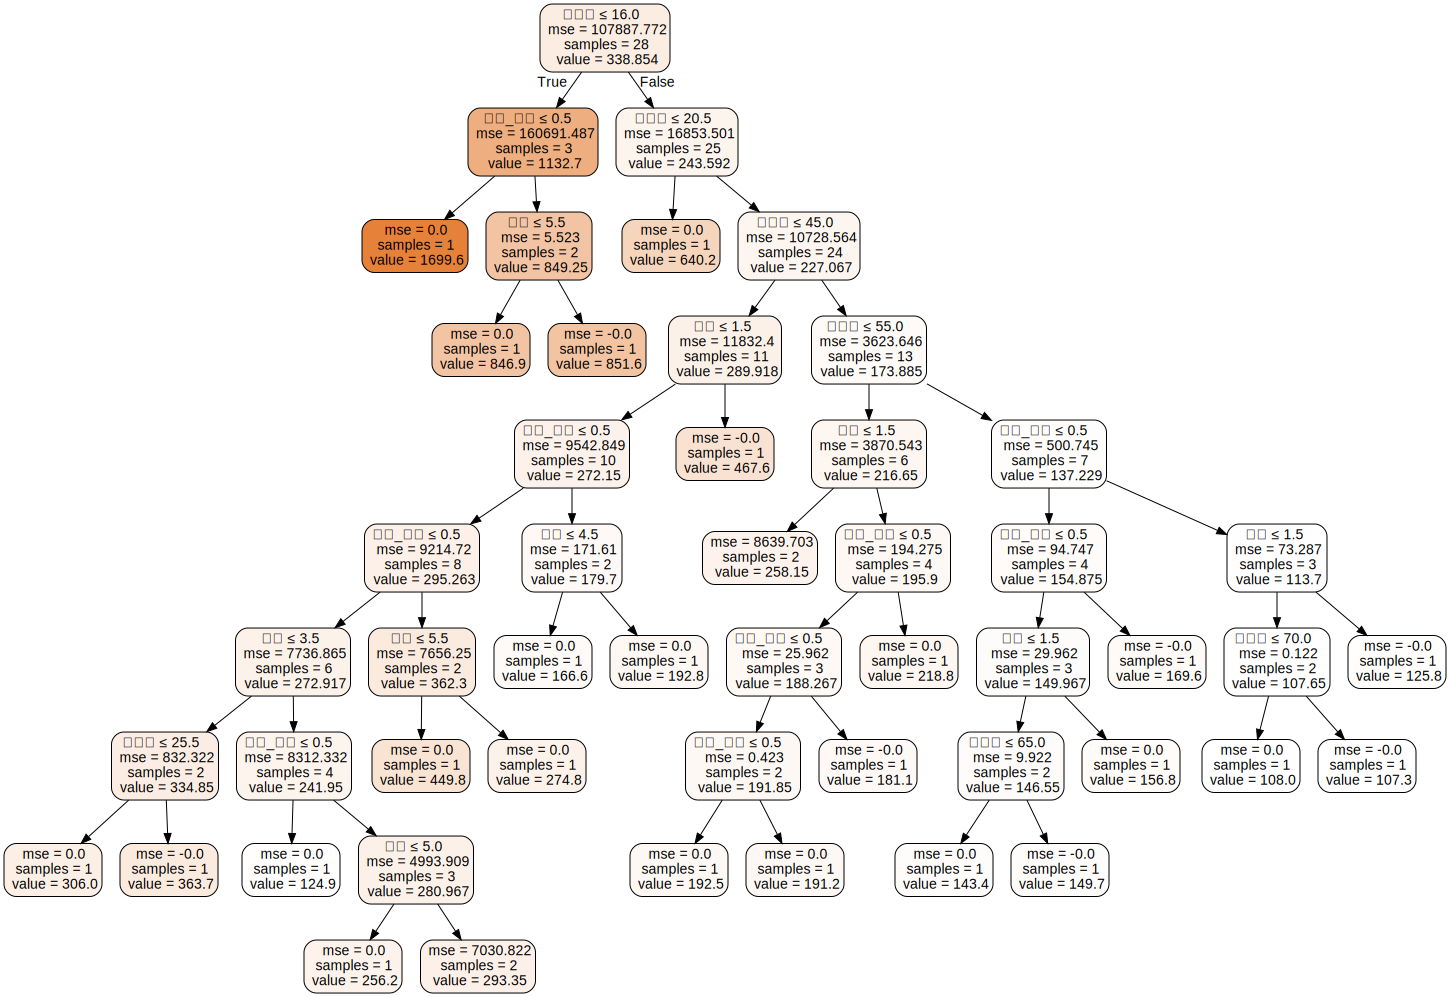

In [7]:
graph

In [54]:
from dtreeviz.trees import dtreeviz
from IPython.display import SVG

# 回帰木の分岐の仕方を可視化
viz = dtreeviz(model, X_train.values, y_train.values, target_name = "y")

# svg形式で保存
name_file = "regression_decisiontree.svg" #ファイル名
path_folder = r"/Users/s.ogura/Documents/CRLEA/data/output"#データが置いてあるフォルダパス
path_file = r'{p}/{n}'.format(p = path_folder, n = name_file)#ファイルパスとファイル名
viz.save(path_file)

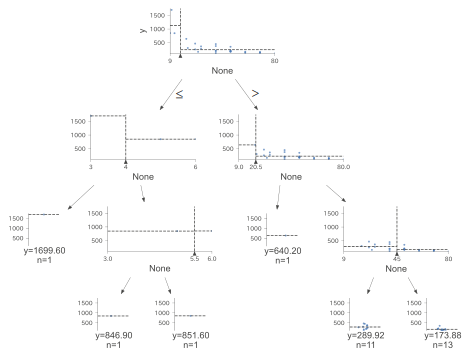

In [55]:
# 分岐可視化
SVG(filename=path_file)

In [60]:
"""
結果の書き出し 
"""

name_excel_output = "result_DTs_v1"
path_folder = r"/Users/s.ogura/Documents/CRLEA/data/output"#Excelが置いてあるフォルダパス

with pd.ExcelWriter('{}/{}.xlsx'.format(path_folder,name_excel_output)) as writer:
    df_res.to_excel(writer, sheet_name=name_excel_output)

## フィードバック

### 村上さんFB
さすがに精度が出ないって感じですね。重要度もありがとうございます。ほぼ0なので、次元が高すぎるってことですね…。<br>
①アルゴリズムをLightGBM→決定木（ディシジョンツリー）に変えましょうか。ブースティングしている場合じゃないかなって思いました。より単純なルール作りをします。<br>
https://scikit-learn.org/stable/modules/tree.html<br>
②秋、冬、夏フラグは、現時点では削除しましょうか。先方から前年（2020年）の分を貰えたら入れてもいいかもです<br>
③分野をどうにかしないとならん感じですね…。ここが一番難しそう。難しいけど、ターゲットエンコーディングにトライするのかな。<br>
④パラメータを小さいデータでも対応できるようにした方が良さそうですね。min_samples_split を2とか1とかにするかな<br>
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html<br>

---
### 山口さん
1.説明変数の増減
   - ハイパーパラメータの変更より、使用している説明変数の増減を試す。
   - あるいは変形（縦の長さと横の長さを素で渡すより、面積としてしか使わない場合は、予め計算してから渡すなど）を試す。
2.方針の立て方
   - この理由でこの変数を入れると予想が正確になるだろうと辺りを立てて、実際に試行錯誤してみる。
   - 何が予測に関与しているか考えを立てて、それを試して予想と合うか、間違っているかを検証していく。
3.閾値
   - 縦軸に最終ペース（あるいは乖離度）、横軸に文字数をマッピングして、直線か、傾いてるか。
4.手法について
   - lightGBMは早くて説明がしやすいため、初手として好まれる。
   - GCPのtableは自動で予測モデルを立ててくれるので、楽。
   - iteration、あるいは学習時間（iterationで考えない場合）ごとに図示をして、頭打ちかどうかを調べてみる。